# PCA OLS Sign

In a prior notebook ```PCARawBacktest.ipynb``` the index was traded conditioned on the raw PC value. It was assumed that the raw PCs should be traded long. First start by seeing if that approach is reasonable via measuring the $\beta$ of the OLS

## Packages

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [3]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/FXCarryEconomicSurprise/root/src")
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FXCarryCitiSurprise\root\src")
from CitiPCA import PCAModel

In [11]:
def _get_lag_signal(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(lag_signal = lambda x: x.value.shift()).
        dropna())
    
    return df_out

def get_data() -> pd.DataFrame:

    keep_values = "FXCARRSP"

    df_out = (PCAModel().get_misc_indices().query(
        "security == @keep_values").
        pivot(index = "date", columns = "security", values = "rtn").
        merge(right = PCAModel().pca(), how = "inner", on = ["date"]).
        drop(columns = ["explained_variance_ratio"]).
        groupby("pc").
        apply(_get_lag_signal).
        reset_index(drop = True))
    
    return df_out

df = get_data()

## Full Sample OLS

First start with a full sample OLS model of each PC. 

In [64]:
def _get_full_sample_ols(df: pd.DataFrame) -> pd.DataFrame:
    
    df_tmp = (df.set_index(
        "date"))
    
    model = (sm.OLS(
        endog = df_tmp.FXCARRSP,
        exog  = sm.add_constant(df_tmp.value)).
        fit())
    
    df_value = (model.params.to_frame(
        name = "value").
        reset_index())
    
    df_pvalue = (model.pvalues.to_frame(
        name = "pvalue").
        reset_index())

    df_out = (df_value.merge(
        right = df_pvalue, how = "inner", on = ["index"]))
    
    return df_out

def get_full_sample_ols(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.groupby(
        "pc").
        apply(_get_full_sample_ols).
        reset_index().
        drop(columns = ["level_1"]).
        rename(columns = {"index": "param"}).
        assign(param = lambda x: np.where(x.param == "const", "alpha", "beta")))
    
    return df_out

df_params = get_full_sample_ols(df)

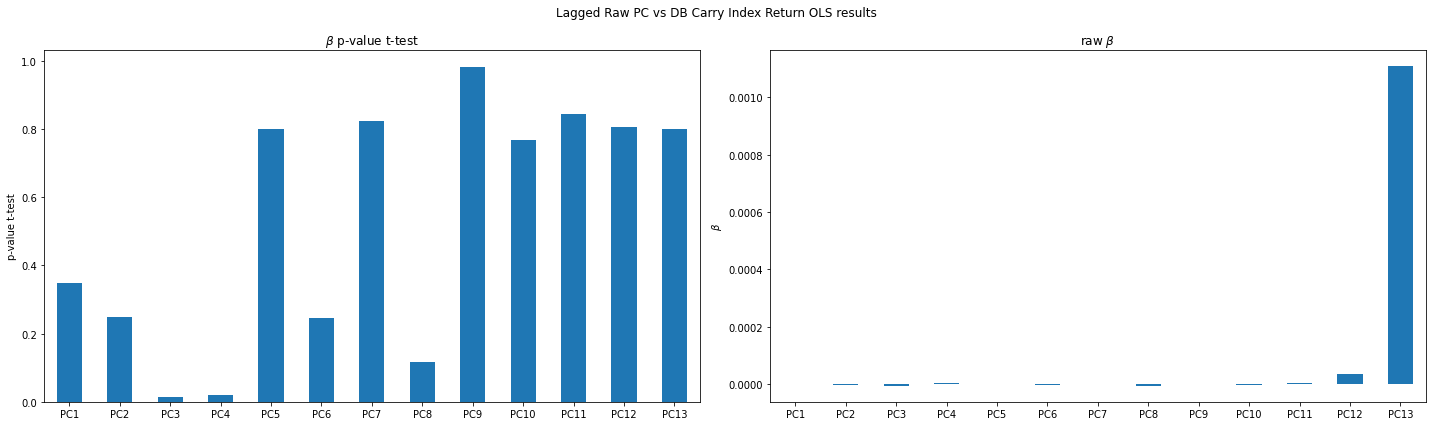

In [65]:
def plot_beta_result(df_params: pd.DataFrame) -> plt.Figure: 
    
    df_longer = (df_params.query(
        "param == 'beta'").
        drop(columns = ["param"]).
        rename(columns = {"value": "raw_value"}).
        melt(id_vars = "pc"))

    variables = df_longer.variable.drop_duplicates().sort_values().to_list()
    title_renamer = {
        "pvalue"   : r"$\beta$" + " p-value t-test",
        "raw_value": "raw " + r"$\beta$"}

    ylabel_renamer = {
        "pvalue"   : "p-value t-test",
        "raw_value": r"$\beta$"}

    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()): 

        (df_longer.query(
            "variable == @variable").
            assign(tmp = lambda x: x.pc.str.replace("PC", "").astype(int)).
            sort_values("tmp").
            set_index("pc")
            [["value"]].
            plot(
                ax     = ax,
                kind   = "bar",
                rot    = 0,
                legend = False,
                xlabel = "",
                ylabel = ylabel_renamer[variable],
                title  = title_renamer[variable]))
        
    fig.suptitle("Lagged Raw PC vs DB Carry Index Return OLS results")
    plt.tight_layout()
    
plot_beta_result(df_params)

This is quite important as it implies that trading the index based on the raw PCs will likely not work, and assuming that the index can be traded based on the index was an innacurate assumption. 